Now that we know how to read the data, we will add some processing to generate a gridded field.<br />
In the first part, we will use the loop on the files to store all the data, then in the second part we will compute a mean value for each grid point of the grid.

First we select a year and a month:

In [2]:
year = 2015
month = 7

In [3]:
%matplotlib inline
import glob
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib  import colors

The directory where we store the data files:

In [4]:
basedir = "/home/ctroupin/DataOceano/MyOcean/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/" + str(year) + str(month).zfill(2) + '/'

# Reading all the data

The loop is the same as the 2 previous examples, except that now we will keep the data in arrays that we create empty:

In [32]:
lon_checked, lat_checked, temperature_checked = np.array([]), np.array([]), np.array([])

filelist = sorted(glob.glob(basedir+'*.nc'))
k = 0
for datafiles in filelist:

    # print datafiles
    with netCDF4.Dataset(datafiles) as nc:
        
        lon = nc.variables['LONGITUDE'][:]
        lat = nc.variables['LATITUDE'][:]
        depth = nc.variables['DEPH'][:]
        POSITION_QC = nc.variables['POSITION_QC'][:]
        
        if depth.shape[1] == 1:

            try:
                TEMP_QC = nc.variables['TEMP_QC'][:, 0]
                temperature = nc.variables['TEMP'][:]         
                gooddata = np.where(np.logical_and((TEMP_QC == 1), (POSITION_QC == 1)))
               
                temperature = temperature[gooddata]
                
                temperature_checked = np.append(temperature_checked, temperature)
                lon_checked = np.append(lon_checked, lon[gooddata])
                lat_checked = np.append(lat_checked, lat[gooddata])
        
            except KeyError:
                k += 1
                # print 'No variable temperature in this file'

Now we have the coordinates and the temperature for all the files, we can save them in a file that we can re-use later. To do so, we will use the numpy [savetxt](http://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html) function.
The function requires:
* the name of the file where the data will be written,
* the data to be saved, in the form of an array.
To create a unique array from the different arrays (coordinates and temperature), we use the function [c_](http://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html).


In [33]:
datafile = './lon_lat_temperature_' + str(year) + '_' + str(month).zfill(2) + '.txt'
np.savetxt(datafile, np.c_[lon_checked, lat_checked, temperature_checked], fmt='%3.5f %3.5f %2.2f')

print 'Data saved in file ' + datafile

Data saved in file ./lon_lat_temperature_2015_07.txt


# Creation of a gridded field

There are many ways of getting a gridded field from sparsely distributed observations. We will show two simple applications.

## Linear interpolation

With scipy, the module [interpolate](http://docs.scipy.org/doc/scipy/reference/interpolate.html) provide many functions to perform interpolations.<br /> 
In particular, [griddata](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) aims to interpolate unstructured D-dimensional data.

In [34]:
from scipy.interpolate import griddata 

We need to specify the grid on which the observations have to be interpolated.<br/>
We construct a 5º by 5º grid between 70ºS and 70ºN latitude.

In [38]:
lon_interp, lat_interp = np.meshgrid(np.arange(-180, 180.5, 5.), np.arange(-70, 70., 5.))

The interpolated field is obtained as:

In [39]:
temperature_interp = griddata((lon_checked, lat_checked), temperature_checked, (lon_interp, lat_interp), method='linear')

After the interpolation and prior to the plot, it is necessary to mask the NaN values that could have been generated.

In [44]:
temperature_interp = np.ma.masked_where(np.isnan(temperature_interp), temperature_interp)

## Plotting

Same code as in the previous examples. [pcolormesh](http://matplotlib.org/examples/pylab_examples/pcolor_demo.html) (pseudocolor plot of a 2-D array) is used for the representation of the gridded field.

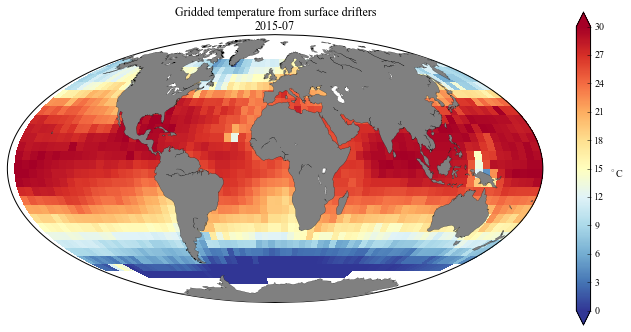

In [43]:
fig = plt.figure(figsize=(12, 8))
tempmin, tempmax = 0., 30.
cmaptemp = plt.cm.RdYlBu_r
normtemp = colors.Normalize(vmin=tempmin, vmax=tempmax)
tempticks = np.arange(tempmin, tempmax+0.1,2.5)

m = Basemap(projection='moll', lon_0=0, resolution='c')
lon_interp_map, lat_interp_map = m(lon_interp, lat_interp)

pcm = m.pcolormesh(lon_interp_map, lat_interp_map, temperature_interp, cmap=cmaptemp, norm=normtemp)

cbar = plt.colorbar(pcm, extend='both', shrink=0.7)
cbar.set_label('$^{\circ}$C', rotation=0, ha='left')
m.drawcoastlines(linewidth=0.2)
m.fillcontinents(color = 'gray')
plt.title('Gridded temperature from surface drifters\n' + str(year) + '-' + str(month).zfill(2))
plt.show()

The chosen method (linear) is far from the best, but the goal is simply to illustrate the tool with the drifter data.<br /> 
We check that the min/max values are consistent with the data:

In [45]:
print temperature_interp.min()
print temperature_interp.max()

-2.95728333526
32.4052053629


In [46]:
print temperature_checked.min()
print temperature_checked.max()

-3.0
35.2999992371


## Interpolation in a specific region

If we want to focus on a given area and increase the resolution, we just have to change the interpolation grid:

In [59]:
lon_interp, lat_interp = np.meshgrid(np.arange(-60., 0.1, 2.), np.arange(0, 70.1, 2.))
temperature_interp = griddata((lon_checked, lat_checked), temperature_checked, (lon_interp, lat_interp), method='linear')
temperature_interp = np.ma.masked_where(np.isnan(temperature_interp), temperature_interp)

On the map we will also add the data locations.

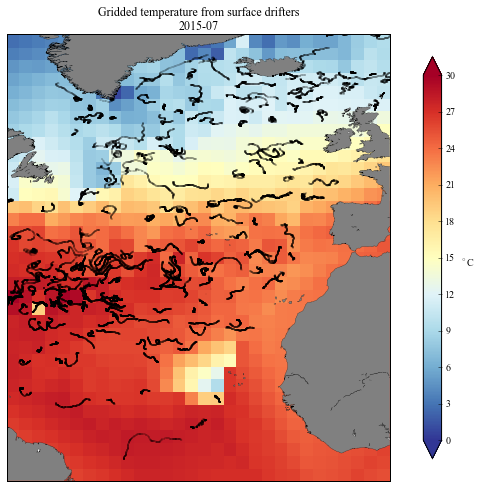

In [60]:
fig = plt.figure(figsize=(12, 8))
m = Basemap(llcrnrlon=-60., llcrnrlat=0.0,
            urcrnrlon=0.0, urcrnrlat=70., resolution='i')

lon_interp_map, lat_interp_map = m(lon_interp, lat_interp)
lon_checked_map, lat_checked_map = m(lon_checked, lat_checked)
pcm = m.pcolormesh(lon_interp_map, lat_interp_map, temperature_interp, cmap=cmaptemp, norm=normtemp)
plt.plot(lon_checked_map, lat_checked, 'ko', ms=0.1)

cbar = plt.colorbar(pcm, extend='both', shrink=0.9)
cbar.set_label('$^{\circ}$C', rotation=0, ha='left')
m.drawcoastlines(linewidth=0.2)
m.fillcontinents(color = 'gray')
plt.title('Gridded temperature from surface drifters\n' + str(year) + '-' + str(month).zfill(2), fontsize=20)
plt.show()